In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import re
import nltk
import math
import numpy as np
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import sklearn.metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, cross_val_predict

In [2]:
df = pd.read_csv('xtal_2.csv',header = None)
df.head(10)

,0,1,2
0,ATCG3D_18,DYKDDDDAMGQPGNGSAFLLAPNRSHAPDHDVTQQRDEVWVVGMGI...,1
1,BSGCAIR30348,MDKKYDITAVLNEDSSMTAISDQFQITLDARPKHTAKGFGPLAALL...,1
2,BSGCAIR30512,MTESFTRRERLRLRRDFLLIFKEGKSLQNEYFVVLFRKNGLDYSRL...,1
3,BSGCAIR30561,MEHDERTHVPVELRAAGVVLLNERGDILLVQEKGIPGHPEKAGLWH...,1
4,BSGCAIR30591,MFYKEENFKKTEIGEIPEDWEIVELKDVCKKIKAGGTPKTSVEEYY...,1
5,BSGCAIR30656,MAIRLYKLAVALGVFIVSAPAFSHGHHSHGKPLTEVEQKAANGVFD...,1
6,BSGCAIR31213,MKDIDTLISNNALWSKMLVEEDPGFFEKLAQAQKPRFLWIGCSDSR...,1
7,GO.102486,GSHMQRQRPPSRAGGDMDRLQSALALYEEAMGYTYAAALRAAAAVG...,1
8,GO.102706,LDQILRATVEEVRAFLGTDRVKVYRFDPEGHGTVVAEARGGERLPS...,1
9,GO.110986,GSPDPEIFRQRFRQFGYQDSPGPREAVSQLRELCRLWLRPETHTKE...,1


In [3]:
df.columns = ['id','sequence','result']
df.head()

,id,sequence,result
0,ATCG3D_18,DYKDDDDAMGQPGNGSAFLLAPNRSHAPDHDVTQQRDEVWVVGMGI...,1
1,BSGCAIR30348,MDKKYDITAVLNEDSSMTAISDQFQITLDARPKHTAKGFGPLAALL...,1
2,BSGCAIR30512,MTESFTRRERLRLRRDFLLIFKEGKSLQNEYFVVLFRKNGLDYSRL...,1
3,BSGCAIR30561,MEHDERTHVPVELRAAGVVLLNERGDILLVQEKGIPGHPEKAGLWH...,1
4,BSGCAIR30591,MFYKEENFKKTEIGEIPEDWEIVELKDVCKKIKAGGTPKTSVEEYY...,1


In [4]:
df.shape

(4791, 3)

In [5]:
df.dtypes

id          object
sequence    object
result       int64
dtype: object

In [6]:
# Count the number of 0's(failures) & 1's,(success) in the result column
df.groupby('result')['result'].value_counts()

result  result
0       0         3913
1       1          878
Name: result, dtype: int64

## Create small dataframe of equal number of proteins that crystallized & ones that did not crystallize.

In [7]:
crystals = df[df.result == 1]
crystals.head()

,id,sequence,result
0,ATCG3D_18,DYKDDDDAMGQPGNGSAFLLAPNRSHAPDHDVTQQRDEVWVVGMGI...,1
1,BSGCAIR30348,MDKKYDITAVLNEDSSMTAISDQFQITLDARPKHTAKGFGPLAALL...,1
2,BSGCAIR30512,MTESFTRRERLRLRRDFLLIFKEGKSLQNEYFVVLFRKNGLDYSRL...,1
3,BSGCAIR30561,MEHDERTHVPVELRAAGVVLLNERGDILLVQEKGIPGHPEKAGLWH...,1
4,BSGCAIR30591,MFYKEENFKKTEIGEIPEDWEIVELKDVCKKIKAGGTPKTSVEEYY...,1


In [8]:
crystals.shape

(878, 3)

In [9]:
no_xtal = df[df.result == 0]
no_xtal.head()

,id,sequence,result
426,APC7908,MNQHLLGNPKLTVTHVNEVKAGINHIVVDSVQYGNQEMIMEKDGTV...,0
439,APC7603,MSETATWQPSASIPNLLKRAAIMAEIRRFFADRGVLEVETPCMSQA...,0
519,hsk002000585.2,RRAGSVKRGEARLFGPTERQSERPLRPSAARRPEMLSGKKAAAAAA...,0
881,GO.35285,MARRKRRNFSKQASEILNEYFYSHLSNPYPSEEAKEELARKCGITV...,0
882,GO.36643,SEKLAASTEPQGPRPVLGRESVQVPDDQDFRSFRSECEAEVGWNLT...,0


In [10]:
no_xtal.shape

(3913, 3)

In [11]:
df_xtal = crystals.sample(n=400)
df_no_xtal = no_xtal.sample(n=400)

In [12]:
df_xtal.shape

(400, 3)

In [13]:
df_no_xtal.shape

(400, 3)

In [14]:
# concat the two dataframes
df_rand = pd.concat([df_xtal,df_no_xtal])
# permute/scramble/shuffle rows of the dataframe
df_rand = df_rand.sample(frac=1)
df_rand.head(3)

,id,sequence,result
590,hss001002011.2,EVQKPLHEQLWYHGAIPRAEVAELLVHSGDFLVRESQGKQEYVLSV...,1
431,IDP01112,MANFEDFLTLDLRIGTVTHAEEFKEARVPAIKLEIDFGELGMKQSS...,1
2052,MytuD.00386.a,MSDLVRVERKGRVTTVILNRPASRNAVNGPTAAALCAAFEQFDRDD...,0


In [15]:
df_rand.shape

(800, 3)

In [16]:
df_rand.dtypes

id          object
sequence    object
result       int64
dtype: object

## Transform the data first with countVectorizer, then split the data

In [17]:
vect_3 = CountVectorizer(min_df=1,token_pattern=r'\w{1}',ngram_range=(3, 3))
#vect_3.fit(df.sequence)

In [18]:
X = vect_3.fit_transform(df_rand.sequence)
y = df_rand.result

In [19]:
#print(vect_3.get_feature_names())

## Split the data into training & test sets

In [20]:
# Note: will try to split the data first, then transform with the vectorizer
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state =42)

In [21]:
# Count the number of 0's(failures) & 1's,(success) in the result column
y_train.value_counts()

1    324
0    316
Name: result, dtype: int64

In [22]:
X_train.shape

(640, 7669)

In [23]:
# Count the number of 0's(failures) & 1's,(success) in the result column
y_test.value_counts()

0    84
1    76
Name: result, dtype: int64

In [24]:
X_train

<640x7669 sparse matrix of type '<class 'numpy.int64'>'
	with 146474 stored elements in Compressed Sparse Row format>

In [25]:
X_test

<160x7669 sparse matrix of type '<class 'numpy.int64'>'
	with 35998 stored elements in Compressed Sparse Row format>

In [26]:
y_train

855     1
111     1
462     1
1931    0
667     1
       ..
301     1
3203    0
3946    0
49      1
2878    0
Name: result, Length: 640, dtype: int64

In [27]:
y_test

260     1
622     1
1115    0
710     1
3005    0
       ..
2050    0
1177    0
2944    0
2260    0
214     1
Name: result, Length: 160, dtype: int64

In [28]:
# Logistic Regression using CountVectorizer for tripeptide frequency
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.predict(X_test)
print("Score: {:.2f}".format(lr.score(X_test, y_test)))

/Users/scottlew/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Score: 0.98


## Logistic Regression On The Entire Data: unbalanced data set where more proteins failed to crystallize than those that did crystallize.

In [29]:
# scramble the data before using and splitting
data = df.sample(frac=1)
data.shape

(4791, 3)

In [30]:
df.head(3)

,id,sequence,result
0,ATCG3D_18,DYKDDDDAMGQPGNGSAFLLAPNRSHAPDHDVTQQRDEVWVVGMGI...,1
1,BSGCAIR30348,MDKKYDITAVLNEDSSMTAISDQFQITLDARPKHTAKGFGPLAALL...,1
2,BSGCAIR30512,MTESFTRRERLRLRRDFLLIFKEGKSLQNEYFVVLFRKNGLDYSRL...,1


In [31]:
data.head(3)

,id,sequence,result
2245,MytuD.00386.a,MSDLVRVERKGRVTTVILNRPASRNAVNGPTAAALCAAFEQFDRDD...,0
1632,MytuD.00386.a,MSDLVRVERKGRVTTVILNRPASRNAVNGPTAAALCAAFEQFDRDD...,0
1284,MytuD.00386.a,MSDLVRVERKGRVTTVILNRPASRNAVNGPTAAALCAAFEQFDRDD...,0


In [32]:
data.sequence[0]

'DYKDDDDAMGQPGNGSAFLLAPNRSHAPDHDVTQQRDEVWVVGMGIVMSLIVLAIVFGNVLVITAIAKFERLQTVTNYFITSLACADLVMGLAVVPFGAAHILMKMWTFGNFWCEFWTSIDVLCVTASIWTLCVIAVDRYFAITSPFKYQSLLTKNKARVIILMVWIVSGLTSFLPIQMHWYRATHQEAINCYAEETCCDFFTNQAYAIASSIVSFYVPLVIMVFVYSRVFQEAKRQLNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSELDKAIGRNTNGVITKDEAEKLFNQDVDAAVRGILRNAKLKPVYDSLDAVRRAALINMVFQMGETGVAGFTNSLRMLQQKRWDEAAVNLAKSRWYNQTPNRAKRVITTFRTGTWDAYKFCLKEHKALKTLGIIMGTFTLCWLPFFIVNIVHVIQDNLIRKEVYILLNWIGYVNSGFNPLIYCRSPDFRIAFQELLCLRRSSLKHHHHHH'

In [33]:
data.groupby('result')['result'].value_counts()

result  result
0       0         3913
1       1          878
Name: result, dtype: int64

In [34]:
#X = data.sequence
vector_3 = CountVectorizer(min_df=1,token_pattern=r'\w{1}',ngram_range=(3, 3))
X = vector_3.fit_transform(data.sequence)
y = data.result

In [35]:
X.shape

(4791, 7934)

In [36]:
# Now split the data
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.2,random_state =42)

In [37]:
X_train.shape

(3832, 7934)

In [38]:
X_test.shape

(959, 7934)

In [39]:
# Count the number of 0's(failures) & 1's,(success) in the result column
y_train.value_counts()

0    3125
1     707
Name: result, dtype: int64

In [40]:
# Count the number of 0's(failures) & 1's,(success) in the result column
y_test.value_counts()

0    788
1    171
Name: result, dtype: int64

In [41]:
X_train

<3832x7934 sparse matrix of type '<class 'numpy.int64'>'
	with 928234 stored elements in Compressed Sparse Row format>

In [42]:
X_test

<959x7934 sparse matrix of type '<class 'numpy.int64'>'
	with 231786 stored elements in Compressed Sparse Row format>

In [43]:
# Logistic Regression using CountVectorizer for tripeptide frequency
lr = LogisticRegression()
lr.fit(X_train, y_train)
predictions = lr.predict(X_test)
print("Score: {:.2f}".format(lr.score(X_test, y_test)))

/Users/scottlew/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Score: 0.99


In [44]:
predictions

array([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1,

## Confusion Matrix

In [45]:
# Generate Confusion Matrix for Logistic Regression
actual = y_test
predictions = lr.predict(X_test)
#results = confusion_matrix(actual, predictions) 
#print(predictions)
print()
cm = confusion_matrix(actual,predictions)
print(cm)


[[777  11]
 [  0 171]]


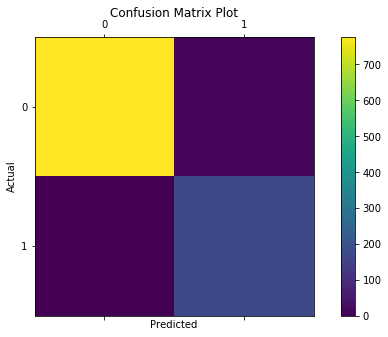

In [46]:
# Nice plot of confusion matrix
# Adjust size of confusion matrix by following code taken from StackOverflow
# https://stackoverflow.com/questions/43021762/matplotlib-how-to-change-figsize-for-matshow
plt.figure(figsize=(10,5))
plt.matshow(cm, fignum=1)

plt.title('Confusion Matrix Plot')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

## Cross Val Score For Logistic Regression Model

In [47]:
vector_3 = CountVectorizer(min_df=1,token_pattern=r'\w{1}',ngram_range=(3, 3))
X = vector_3.fit_transform(data.sequence)
y = data.result
X.shape

(4791, 7934)

In [48]:
#instantiate a logistic regression classifier
lr_cv = LogisticRegression(C=100.0, random_state = 1)
#scores = cross_val_score(lr2,X_scale,y, cv = 10)
scores = cross_val_score(lr_cv,X,y, cv = 5)
print("Cross-validation scores for Logistic Regression: {}".format(scores))
print()
print("The average accuracy score for Logistic Regression is: ")
print(np.mean(scores))

/Users/scottlew/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Cross-validation scores for Logistic Regression: [ 0.99165798  0.97914494  0.98957247  0.99164054  0.99059561]

The average accuracy score for Logistic Regression is: 
0.988522309136


## Predict whether a well-known crystallizable protein, chicken lysozyme, will crystallize or not using tripeptide frequency and Logistic Regression. 

In [49]:
# The following sequence is for the hen egg white lysozyme protein which is known to crystallize
seq = 'KVFGRCELAAAMKRHGLDNYRGYSLGNWVCAAKFESNFNTQATNRNTDGSTDYGILQINSRWWCNDGRTPGSRNLCNIPC\
       SALLSSDITASVNCAKKIVSDGNGMNAWVAWRNRCKGTDVQAWIRGCRL'

In [50]:
data = [seq]

In [51]:
# Note: VERY IMPORTANT! use transform method NOT fit_transform method,
# otherwise new data will NOT BE IN CORRECT FORMAT/SHAPE
X_seq = vector_3.transform(data)
X_seq.toarray()

array([[1, 0, 0, ..., 0, 0, 0]])

In [52]:
X_seq

<1x7934 sparse matrix of type '<class 'numpy.int64'>'
	with 124 stored elements in Compressed Sparse Row format>

In [53]:
X_seq.shape

(1, 7934)

In [54]:
predict = lr.predict(X_seq)[0]
predict

1